In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import re

In [3]:
# Load dataset
file_path = 'Compiled dataset.csv'  # Change to your file path
df = pd.read_csv(file_path)

# Display first few rows of the dataset
df.head()

,links,symbol,company,Title,Text,Publishdate,Industry,Sentiment
0,https://www.cnbc.com/2024/04/03/wednesdays-sto...,RJF,Raymond James,Here are Wednesday's biggest analyst calls: Te...,Here are the biggest calls on Wall Street on W...,3-Apr-24,Financial Services,0.0
1,https://www.cnbc.com/2024/01/04/jim-cramer-rev...,NDAQ,"Nasdaq, Inc.",Jim Cramer reviews the worst performers on the...,CNBC's Jim Cramer on Thursday gave his take on...,4-Jan-24,Financial Services,0.0
2,https://www.cnbc.com/2024/01/04/jim-cramer-rev...,NDAQ,"Nasdaq, Inc.",Jim Cramer reviews the worst performers on the...,CNBC's Jim Cramer on Thursday gave his take on...,4-Jan-24,Financial Services,0.0
3,https://www.cnbc.com/2024/01/04/jim-cramer-rev...,NDAQ,"Nasdaq, Inc.",Jim Cramer reviews the worst performers on the...,CNBC's Jim Cramer on Thursday gave his take on...,4-Jan-24,Financial Services,0.0
4,https://www.cnbc.com/2024/01/04/top-stocks-to-...,CMA,Comerica,Here are Thursday's biggest analyst calls: Nvi...,Here are the biggest calls on Wall Street on T...,4-Jan-24,Financial Services,0.0


In [4]:
df.shape

(5207, 8)

In [5]:
# Preprocessing
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer("english")  # Initialize stemmer

def tokenize(text):
    # Lowercase the text
    text = text.lower()
    # Remove any non-alphabet characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Stem the text
    stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    
    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.columns = df.columns.str.lower()

# Apply preprocessing on 'title' column
df['tokens'] = df['title'].apply(tokenize)

# Output dimensions and shape
print(f"Title: {df['title'].head()[0]}")
print(f"Tokens: {df['tokens'].head()[0]}")

Title: Here are Wednesday's biggest analyst calls: Tesla, Amazon, Alphabet, Meta, UPS, Tyson, Disney, SoFi & more
Tokens: wednesdays biggest analyst calls tesla amazon alphabet meta ups tyson disney sofi


In [7]:
# Load Spacy model
nlp = spacy.load('en_core_web_sm')

# POS Tagging and Chunking Function
def pos_tagging_and_chunking(text):
    doc = nlp(text)
    chunks = []
    for chunk in doc.noun_chunks:
        chunks.append((chunk.text, chunk.root.dep_, chunk.root.head.text)) # chunk text, dependency label, head text
    return chunks

# Apply to the preprocessed text
df['pos_chunks'] = df['tokens'].apply(pos_tagging_and_chunking)

# Check output
print(f"Tokens: {df['tokens'].head()[0]}")
print(f"POS Chunks: {df['pos_chunks'].head()[0]}")

# The POS chunks show extracted noun phrases with their dependency information.

Tokens: wednesdays biggest analyst calls tesla amazon alphabet meta ups tyson disney sofi
POS Chunks: [('biggest analyst', 'nsubj', 'calls'), ('tesla amazon alphabet meta ups tyson disney sofi', 'dobj', 'calls')]


nsubj: Nominal subject (the chunk is the subject of the sentence) \
dobj: Direct object (the chunk is the direct object of the sentence).

In [8]:
def visualize_and_get_topic_weights(lda, lda_topics, vectorizer):

    # Get the number of topics dynamically from the LDA model
    n_topics = lda.components_.shape[0]
    
    # Extract the feature names (words)
    words = vectorizer.get_feature_names_out()
    
    # Print the top 10 words for each topic
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([words[i] for i in topic.argsort()[:-10 - 1:-1]]))
    
    # Create a dataframe to store topic weights for words
    topic_weights = pd.DataFrame(lda.components_, columns=words)
    
    # Transpose the dataframe for better visualization
    topic_weights = topic_weights.T
    
    # Rename columns dynamically based on the number of topics
    topic_weights.columns = [f"Topic #{i}" for i in range(n_topics)]
    
    # Sort values by the highest weight in any topic (you can choose a specific topic if needed)
    topic_weights_sorted = topic_weights.copy()
    topic_weights_sorted["max_weight"] = topic_weights.max(axis=1)
    topic_weights_sorted = topic_weights_sorted.sort_values(by="max_weight", ascending=False).head(10)

    print("\nTop 10 words contributing most to any topic:")
    print(topic_weights_sorted.drop("max_weight", axis=1))
    
    # Visualize the weights using a bubble plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=range(lda_topics.shape[1]), 
        y=lda_topics[0], 
        s=lda_topics[0]*1000, 
        legend=False
    )
    plt.title("Bubble Plot for LDA Topic Modelling")
    plt.show()

Topic #0:
earnings week heres market report investors tech want says big
Topic #1:
round lightning stocks us cramers energy best street wall companies
Topic #2:
stock market top jim watch cramers stocks things cramer thursday
Topic #3:
says ceo stocks new buy us shares bank could early
Topic #4:
biggest stocks making moves analyst calls apple midday tesla nvidia

Top 10 words contributing most to any topic:
            Topic #0    Topic #1    Topic #2    Topic #3    Topic #4
biggest     0.200304    0.200584    0.200549    0.200541  783.198023
stocks     73.899131  139.053853  164.516326  119.288619  498.242071
making      0.200314    0.200613    0.200352    0.200080  475.198642
moves       0.200138    0.200548    0.200170    0.200311  468.198833
analyst     0.201588    0.200418    0.508465    0.200711  356.888818
calls       0.200378    0.200457    0.203598    0.201218  354.194348
stock      61.429552    0.470535  315.482951   49.415505    0.201456
apple       0.201516    0.201452    1

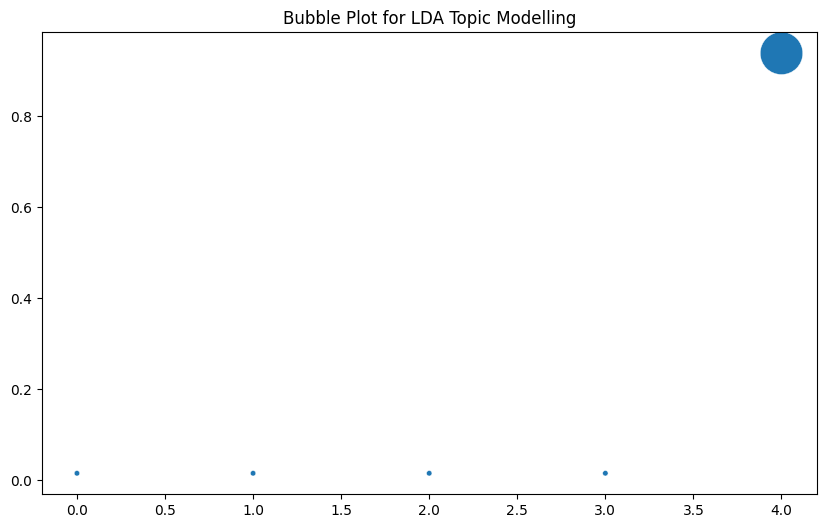

Perplexity value: 1362.1234549166036


In [14]:
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the preprocessed text
vectorizer = CountVectorizer(max_df=0.9, min_df=2) # Convert into numerical value
X = vectorizer.fit_transform(df['tokens'])

# LDA Topic Modelling
lda = LatentDirichletAllocation(n_components=5, random_state=42) # 5 topics to extract
lda_topics = lda.fit_transform(X)

# Visualize the results
def plot_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([words[i] for i in topic.argsort()[:-top_n - 1:-1]]))

# Display LDA
visualize_and_get_topic_weights(lda, lda_topics, vectorizer) # Top 10 text
print(f"Perplexity value: {lda.perplexity(X)}")

How to interpret this graph: \
Vertical axis: Contribution of the topic to this document \
Horizontal axis: Topic Index \
Bubble size: Weight of the topic

Fitting LDA with n_topics = 1
Perplexity for n_topics = 1: 1424.790351691571
Fitting LDA with n_topics = 3
Perplexity for n_topics = 3: 1393.0860564386942
Fitting LDA with n_topics = 5
Perplexity for n_topics = 5: 1362.1234549166036
Fitting LDA with n_topics = 7
Perplexity for n_topics = 7: 1406.1748043518737
Fitting LDA with n_topics = 9
Perplexity for n_topics = 9: 1430.072158534654
Fitting LDA with n_topics = 11
Perplexity for n_topics = 11: 1450.5899876762926
Fitting LDA with n_topics = 13
Perplexity for n_topics = 13: 1482.3461801191736
Fitting LDA with n_topics = 15
Perplexity for n_topics = 15: 1500.1327415447308
Fitting LDA with n_topics = 17
Perplexity for n_topics = 17: 1547.3841925071574
Fitting LDA with n_topics = 19
Perplexity for n_topics = 19: 1535.1725023376653
Fitting LDA with n_topics = 21
Perplexity for n_topics = 21: 1564.0355268461167
Fitting LDA with n_topics = 23
Perplexity for n_topics = 23: 1584.3285737199958
Fitting LDA with n_topics = 25
Perplexity for n_topi

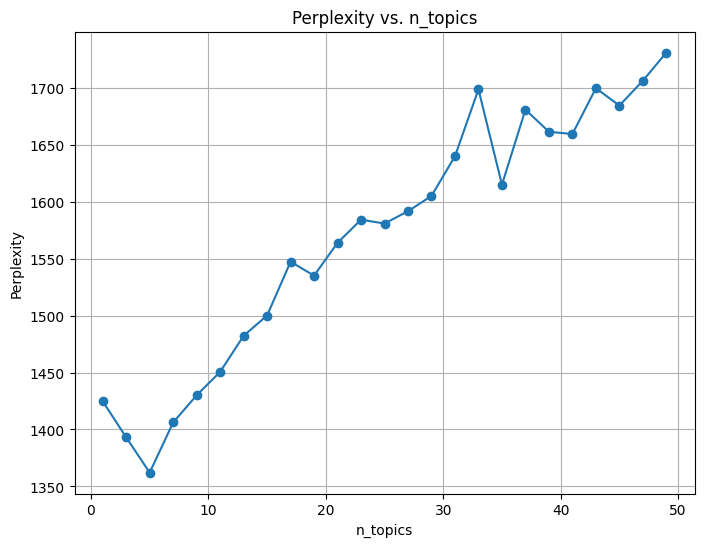

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import log_loss

# Define the different n_topics values to experiment with
n_topics_values = [x for x in range(1, 50, 2)]
perplexity_values = []

# Vectorize the data using TF-IDF
vectorizer = CountVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(df['tokens'])

# Loop over different n_topics values
for n_topics in n_topics_values:
    print(f"Fitting LDA with n_topics = {n_topics}")
    
    # Initialize LDA with current n_topics
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42) 
    
    # Fit the LDA model
    lda_topics = lda.fit_transform(X)
    
    # Calculate and store the perplexity
    perplexity = lda.perplexity(X)
    perplexity_values.append(perplexity)
    
    print(f"Perplexity for n_topics = {n_topics}: {perplexity}")

# Plot perplexity vs. n_topics
plt.figure(figsize=(8, 6))
plt.plot(n_topics_values, perplexity_values, marker='o')
plt.title('Perplexity vs. n_topics')
plt.xlabel('n_topics')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

Fitting LDA with max_iter = 10
Perplexity for max_iter = 10: 1362.1234549166036
Fitting LDA with max_iter = 20
Perplexity for max_iter = 20: 1335.4045279900083
Fitting LDA with max_iter = 30
Perplexity for max_iter = 30: 1321.098024779101
Fitting LDA with max_iter = 40
Perplexity for max_iter = 40: 1314.6976801843564
Fitting LDA with max_iter = 50
Perplexity for max_iter = 50: 1311.9708329966486
Fitting LDA with max_iter = 60
Perplexity for max_iter = 60: 1310.692158324078
Fitting LDA with max_iter = 70
Perplexity for max_iter = 70: 1309.2638825643332
Fitting LDA with max_iter = 80
Perplexity for max_iter = 80: 1308.0387527175735
Fitting LDA with max_iter = 90
Perplexity for max_iter = 90: 1307.3011457815064


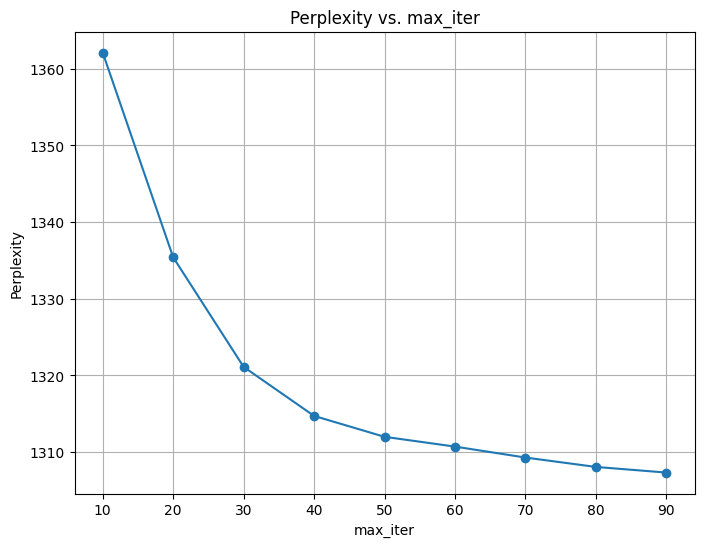

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import log_loss

# Define the different max_iter values to experiment with
max_iter_values = [x for x in range(10, 100, 10)]
perplexity_values = []

# Vectorize the data using TF-IDF
vectorizer = CountVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(df['tokens'])

# Loop over different max_iter values
for max_iter in max_iter_values:
    print(f"Fitting LDA with max_iter = {max_iter}")
    
    # Initialize LDA with current max_iter
    lda = LatentDirichletAllocation(n_components=5, random_state=42, max_iter=max_iter) 
    
    # Fit the LDA model
    lda_topics = lda.fit_transform(X)
    
    # Calculate and store the perplexity
    perplexity = lda.perplexity(X)
    perplexity_values.append(perplexity)
    
    print(f"Perplexity for max_iter = {max_iter}: {perplexity}")

# Plot perplexity vs. max_iter
plt.figure(figsize=(8, 6))
plt.plot(max_iter_values, perplexity_values, marker='o')
plt.title('Perplexity vs. max_iter')
plt.xlabel('max_iter')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

In [19]:
# Dependency Parsing using Spacy
def dependency_parsing(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

# Apply to preprocessed text
df['dependency_parsing'] = df['tokens'].apply(dependency_parsing)

# Check output
print(f"Title: {df['title'].head()[0]}")
print(f"Dependency Parsing: {df['dependency_parsing'].head()[0]}")


Title: Here are Wednesday's biggest analyst calls: Tesla, Amazon, Alphabet, Meta, UPS, Tyson, Disney, SoFi & more
Dependency Parsing: [('wednesdays', 'ROOT', 'wednesdays'), ('biggest', 'amod', 'analyst'), ('analyst', 'nsubj', 'calls'), ('calls', 'ccomp', 'wednesdays'), ('tesla', 'compound', 'sofi'), ('amazon', 'compound', 'alphabet'), ('alphabet', 'compound', 'sofi'), ('meta', 'compound', 'ups'), ('ups', 'compound', 'sofi'), ('tyson', 'compound', 'sofi'), ('disney', 'compound', 'sofi'), ('sofi', 'dobj', 'calls')]


In [25]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

tokens = df['tokens'].apply(lambda x: x.split())
tokens.tolist()

cm = CoherenceModel(topics=topics, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value


[['wednesdays',
  'biggest',
  'analyst',
  'calls',
  'tesla',
  'amazon',
  'alphabet',
  'meta',
  'ups',
  'tyson',
  'disney',
  'sofi'],
 ['jim', 'cramer', 'reviews', 'worst', 'performers', 'nasdaq'],
 ['jim', 'cramer', 'reviews', 'worst', 'performers', 'nasdaq'],
 ['jim', 'cramer', 'reviews', 'worst', 'performers', 'nasdaq'],
 ['thursdays',
  'biggest',
  'analyst',
  'calls',
  'nvidia',
  'apple',
  'nike',
  'home',
  'depot',
  'gm',
  'wells',
  'fargo',
  'coinbase'],
 ['thursdays',
  'biggest',
  'analyst',
  'calls',
  'nvidia',
  'apple',
  'nike',
  'home',
  'depot',
  'gm',
  'wells',
  'fargo',
  'coinbase'],
 ['thursdays',
  'biggest',
  'analyst',
  'calls',
  'nvidia',
  'apple',
  'nike',
  'home',
  'depot',
  'gm',
  'wells',
  'fargo',
  'coinbase'],
 ['thursdays',
  'biggest',
  'analyst',
  'calls',
  'nvidia',
  'apple',
  'nike',
  'home',
  'depot',
  'gm',
  'wells',
  'fargo',
  'coinbase'],
 ['american',
  'express',
  'opening',
  'exclusive',
  'clu